In [1]:
import torch
from supervoice_valle import SupervoceNARModel, Tokenizer
from train.dataset import load_sampler
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from vocos import Vocos

In [2]:
vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz")
tokenizer = Tokenizer("./tokenizer_text.model")
sampler = load_sampler("./external_datasets/libriheavy/libriheavy_cuts_small.jsonl.gz", "./external_datasets/libriheavy-encodec/", 1, tokenizer)
model = SupervoceNARModel()
checkpoint = torch.load("./output/valle-23.pt", map_location = "cpu")
model.load_state_dict(checkpoint['model'])
# model = model.to(torch.float16)
# model = model.to("cuda")
model.eval()
step = checkpoint['step']
print(checkpoint['step'])

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


70000


In [3]:
audio, text = sampler()
print(audio[0], text[0])
encoded = audio[0]
text = text[0]
# id = "./external_datasets/libriheavy-encodec/9774/extermination_american_bison_1503_librivox_64kb_mp3/exterminationamericanbison_12_hornaday_64kb_99"
# with open(id + ".txt", 'r') as file:
#     text = file.read()
#     text = tokenizer.encode(text)
# encoded = torch.load(id + ".pt")

tensor([[ 339,   25,   25,  ...,   25,  537,   25],
        [ 867,  867,  580,  ...,  580,  228,  867],
        [1022,  732,  326,  ..., 1005, 1005, 1015],
        ...,
        [ 975,  238,  185,  ...,  410,  863,  692],
        [ 291,  879,  453,  ...,  562,  772,  671],
        [ 714,  416,  340,  ...,  228, 1013,  309]]) tensor([  61,   52,  241, 1293, 1073,  121,   33,  239,   78,  209, 2050,   78,
          52,  185, 3431,   28,   52,   33,  217,  140, 2258,  309,   11, 1163,
         390,   33,  280,   33,  189,  455,   10,   17,   56,   42,   25,   20,
        1547,  189,   45,   52, 1308, 1852,  109,  257, 2258,  309, 1163,   71,
          12])


In [4]:
def decode(tokens):
    features = vocos.codes_to_features(tokens)
    bandwidth_id = torch.tensor([2])  # 6 kbps
    return vocos.decode(features, bandwidth_id=bandwidth_id)
display(Audio(data=decode(encoded).cpu(), rate=24000))
print(encoded.shape)

torch.Size([8, 444])


In [5]:
condition_text = text
condition_audio = encoded[:,:75*3]
audio = encoded[:,75*3:]
predicted = [audio[0]]
print(audio[0])
for i in range(1, 8):
    p = model(
        condition_text = [condition_text], 
        condition_audio = [condition_audio],
        audio = [torch.stack(predicted)],
        codec = [i]
    )

    p = p[0]
    p = torch.nn.functional.softmax(p, dim=-1)
    # print(p.shape)

    # for j in range(len(audio[i])):
    #     print(p[j][audio[i][j]].item(), torch.max(p[j]).item())

    # Top-3
    # p = p[0]
    # v, _ = torch.topk(p.unsqueeze(0), 10)
    # v = v.squeeze(0)
    # p[p < v[:, [-1]]] = -float('Inf')

    # Sample
    # p = torch.nn.functional.softmax(p, dim=-1)
    # p = torch.multinomial(p, num_samples=1)
    # p = p.squeeze(-1)

    p = torch.argmax(p, dim=-1, keepdim=True)
    p = p.squeeze(-1)

    print("inference")
    print(p)
    print(audio[i])
    predicted.append(p.cpu())
predicted = torch.stack(predicted)
predicted = torch.cat([condition_audio, predicted], dim = 1)
display(Audio(data=decode(predicted).cpu(), rate=24000))

tensor([ 872,  916,  731,  819,  738,  408,  408,  103,  254,  145,  145,   38,
          38,  103, 1004,  461, 1022,  901,  495,   73,  833,  457, 1011,   73,
         323,   23,  779, 1017,   25,  677,  192,  472,  677,  602,  192,  411,
         602,  568,  602,  433,  499,  213,  612,  505, 1001,   59,   23,   23,
         404,  121,  430,  876,  724,  432,  731,   30,  612,  213,  192,   38,
         145,  145,  145,  145,   53,  103,  339,  339,   25,  488,   38,   38,
          38,  103,  537,   91,   11,   11,  833,  833,  944,  944,  588,  833,
         833,  901,  645,  843,  132,  914,  388,  505,  602,  433,   23,  276,
         677,  865,  780,  408,  738,  475,  694,   63,  213,  730,  568,  568,
         230,  755,  916,  779, 1019,  904,  106,  106,  395,   40,  537,  537,
         537,  537,  537, 1008,  573,  951,  997,  951,  132,  413,  582,  650,
         327,  151,  185,  906,  424,  563, 1001, 1001,  976,  976,  871,  495,
         645,  421,  421,   11,  203,  2

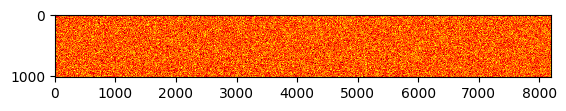

In [6]:
plt.imshow(model.positional_embedding_text.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

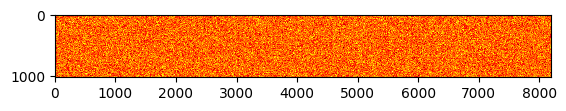

In [7]:
plt.imshow(model.positional_embedding_audio.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [8]:
# for i in range(step - 40000, step, 5000):
#     checkpoint = torch.load("./output/valle-23." + str(i) + ".pt", map_location = "cpu")
#     model.load_state_dict(checkpoint['model'])

#     condition_text = text
#     condition_audio = encoded[:,:75*3]
#     audio = encoded[:,75*3:]
#     predicted = [audio[0]]
#     for i in range(1, 8):
#         p = model(
#             condition_text = [condition_text], 
#             condition_audio = [condition_audio],
#             audio = [torch.stack(predicted)],
#             codec = [i]
#         )
#         p = p[0]
#         p = torch.nn.functional.softmax(p, dim=-1)
#         p = torch.argmax(p, dim=-1, keepdim=True)
#         p = p.squeeze(-1)
#         predicted.append(p.cpu())
#     predicted = torch.stack(predicted)
#     predicted = torch.cat([condition_audio, predicted], dim = 1)
#     display(Audio(data=decode(predicted).cpu(), rate=24000))